In [2]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "DejaVu Serif"
import matplotlib as mpl
import h5py
import multiprocessing
from tqdm import tqdm



# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"
from tqdm import tqdm
import gc
import os

Snapshot_Init = 71
Current_Snapshot = 99

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum}
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sun/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sun/h/(kpc/h)^3


In [3]:
Gas_Fields=['Masses','Coordinates','NeutralHydrogenAbundance']
Stars_Fields=['Masses','Coordinates']

In [4]:
def batch_distance_calculation(pos1, pos2, boxsize=None):
    # 计算每个点与目标点的距离
    dxs = np.abs(pos1[:, 0] - pos2[0])
    dys = np.abs(pos1[:, 1] - pos2[1])
    dzs = np.abs(pos1[:, 2] - pos2[2])

    # 考虑周期性边界条件
    if boxsize is not None:
        dxs2 = np.abs(boxsize - dxs)
        dys2 = np.abs(boxsize - dys)
        dzs2 = np.abs(boxsize - dzs)

        # 在周期性边界条件下，选择最短的距离
        dxs = np.minimum(dxs, dxs2)
        dys = np.minimum(dys, dys2)
        dzs = np.minimum(dzs, dzs2)

    # 计算三维空间点之间的欧氏距离
    distances = np.linalg.norm(np.vstack([dxs, dys, dzs]).T, axis=1)

    return distances


def Radius90(Particles_Coordinates,Particles_Masses,Center):
    boxsize=51700
    Particles_Distance=batch_distance_calculation(Particles_Coordinates,Center,boxsize)
    Particles_Distance_Sorted=np.sort(Particles_Distance)
    Particles_Masses_Sorted=Particles_Masses[np.argsort(Particles_Distance)]
    Masses_Cumulative=np.cumsum(Particles_Masses_Sorted)
    Masses_Cumulative_Normalized=Masses_Cumulative/Masses_Cumulative[-1]
    Radius90=Particles_Distance_Sorted[np.where(Masses_Cumulative_Normalized>=0.9)[0][0]]
    Radius60=Particles_Distance_Sorted[np.where(Masses_Cumulative_Normalized>=0.6)[0][0]]
    Radius50=Particles_Distance_Sorted[np.where(Masses_Cumulative_Normalized>=0.5)[0][0]]
    return Radius90,Radius60,Radius50

#def a function, given the Particles_Coordinates, Particles_Masses, Center, return a radius of a sphere which has the density of a given value



In [19]:
Subhalo_Index=329508
Current_Snapshot=99
Subhalo_Tree=il.sublink.loadTree(basePath, Current_Snapshot, Subhalo_Index,fields=['SnapNum','SubfindID'],onlyMPB=True)

In [ ]:
Subhalo_Tree

In [18]:
Full_Snapshots=np.array([99,91,84,78,72,67,59,50,40,33,25,21,17,13,11,8,6,4,3,2])

In [81]:
HI_R90=list()

for Current_Snapshot, Subhalo_Index in tqdm(zip(Subhalo_Tree['SnapNum'],Subhalo_Tree['SubfindID'])):

    Subhalo_Dict=il.groupcat.loadSingle(basePath, Current_Snapshot, -1,Subhalo_Index)
    Subhalo_Center=Subhalo_Dict['SubhaloPos']/h
    Subhalo_Mass=Subhalo_Dict['SubhaloMass']/h

    if Current_Snapshot in Full_Snapshots:
        Gas_Dict=il.snapshot.loadSubhalo(basePath, Current_Snapshot, Subhalo_Index,'gas',fields=Gas_Fields)
        Gas_Coordinates=Gas_Dict['Coordinates']/h
        Gas_Masses=Gas_Dict['Masses']/h
        Gas_NeutralHydrogenAbundance=Gas_Dict['NeutralHydrogenAbundance']
        Gas_NeutralHydrogen_Masses=Gas_Masses*Gas_NeutralHydrogenAbundance
        ratio=Subhalo_Dict['SubhaloMassType'][0]/np.sum(Gas_NeutralHydrogen_Masses)/25
        HI_Radius90=Density_Radius(Gas_Coordinates,Gas_NeutralHydrogen_Masses,Subhalo_Center,ratio)
        HI_R90.append(HI_Radius90)


99it [00:47,  2.09it/s]


In [80]:


#use a function Density_Radius to calculate
def Density_Radius(Particles_Coordinates,Particles_Masses,Subhalo_Center,Ratio):
    boxsize=51700
    Particles_Distance=batch_distance_calculation(Particles_Coordinates,Subhalo_Center,boxsize)
    Particles_Distance_Sorted=np.sort(Particles_Distance)
    Particles_Masses_Sorted=Particles_Masses[np.argsort(Particles_Distance)]
    Masses_Cumulative=np.cumsum(Particles_Masses_Sorted)
    Density_Cumulative=Masses_Cumulative/(4/3*np.pi*np.power(Particles_Distance_Sorted,3))
    Density_Cumulative_Normalized=Density_Cumulative/Critial_Density/200
    Radius=Particles_Distance_Sorted[np.argmax(Density_Cumulative_Normalized):][np.where(Density_Cumulative_Normalized[np.argmax(Density_Cumulative_Normalized):]<Ratio)[0][0]]

    return Radius

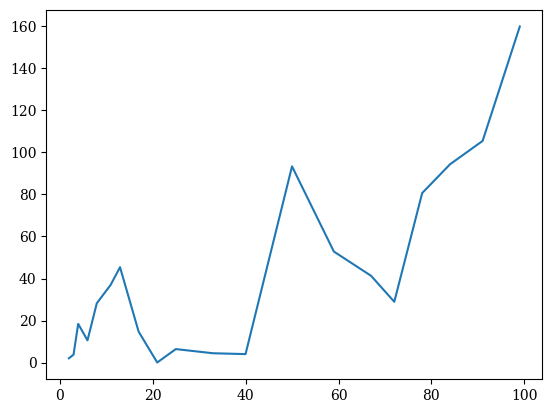

In [82]:
plt.plot(Full_Snapshots,HI_R90)

In [83]:
HI_R90

[159.9037788583252,
 105.46302033517655,
 94.36874100902322,
 80.65831766084709,
 28.93877439460174,
 41.30414407522569,
 52.84019410778173,
 93.3510284375349,
 4.053383119145267,
 4.458662524656253,
 6.436241631640975,
 0.06735664899678655,
 14.744210241865908,
 45.39829863493446,
 37.04040169238007,
 28.22600578407006,
 10.58605965868579,
 18.431281220577418,
 3.801657808690961,
 2.067862316002757]